In [1]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
import pandas as pd
import numpy as np
import random
import os
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
import time
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams['axes.unicode_minus']=False

path = 'result/reservoir-jacobian'
if not os.path.exists(path):
    os.makedirs(path)
    

class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))

In [22]:
seed = 42
random.seed(seed) 
np.random.seed(seed)

system_name = 'Lorenz'
dim = [0,1,2]
Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
U0 = Y[dim].copy()
U = U0 + np.random.randn(*U0.shape)*1e-3
U = np.atleast_2d(U)

num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000
print('U shape:', U.shape)
print('Y shape:', Y.shape)


inSize = U.shape[0]
outSize = 3  
resSize = 100
reg = 1e-6 
a = 0.1
K = 1.9
input_scaling = 1

U_train = U[:,train_start : train_start + num_train]
Y_train = Y[:,train_start + 1 : train_start + num_train + 1]


Win = (np.random.rand(resSize,1+inSize)-0.5) * (input_scaling * 2)
W = np.random.rand(resSize,resSize)-0.5
largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*K 

X = np.zeros((resSize,U.shape[1]))
x = np.zeros([resSize,1])
for t in range(U.shape[1]):
    u = U[:,t:t+1]
    x = (1-a) * x + a * np.tanh(Win @ np.vstack((1,u)) + W @ x) 
    X[:,t:t+1] = x


X_train = X[:,train_start : train_start + num_train]
# H = np.vstack((np.ones((1,X_train.shape[1])),X_train))
H = X_train

Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))

X_test = X[:,test_start : test_start + num_test]
Y_test = Y[:,test_start + 1 : test_start + num_test + 1]
# err = Y_test - Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
err = Y_test - Wout @ X_test
err = np.average(np.square(err), axis=1)
print(err)

U shape: (3, 20000)
Y shape: (3, 20000)
[6.08095082e-08 1.53139631e-07 1.52503986e-07]


In [26]:
J = []
for i in range(num_train):
    jacob = Wout @ (1 - np.diag(X_train[:,i])**2) @ Win[:,1:]
    J.append(jacob)
J = np.array(J)

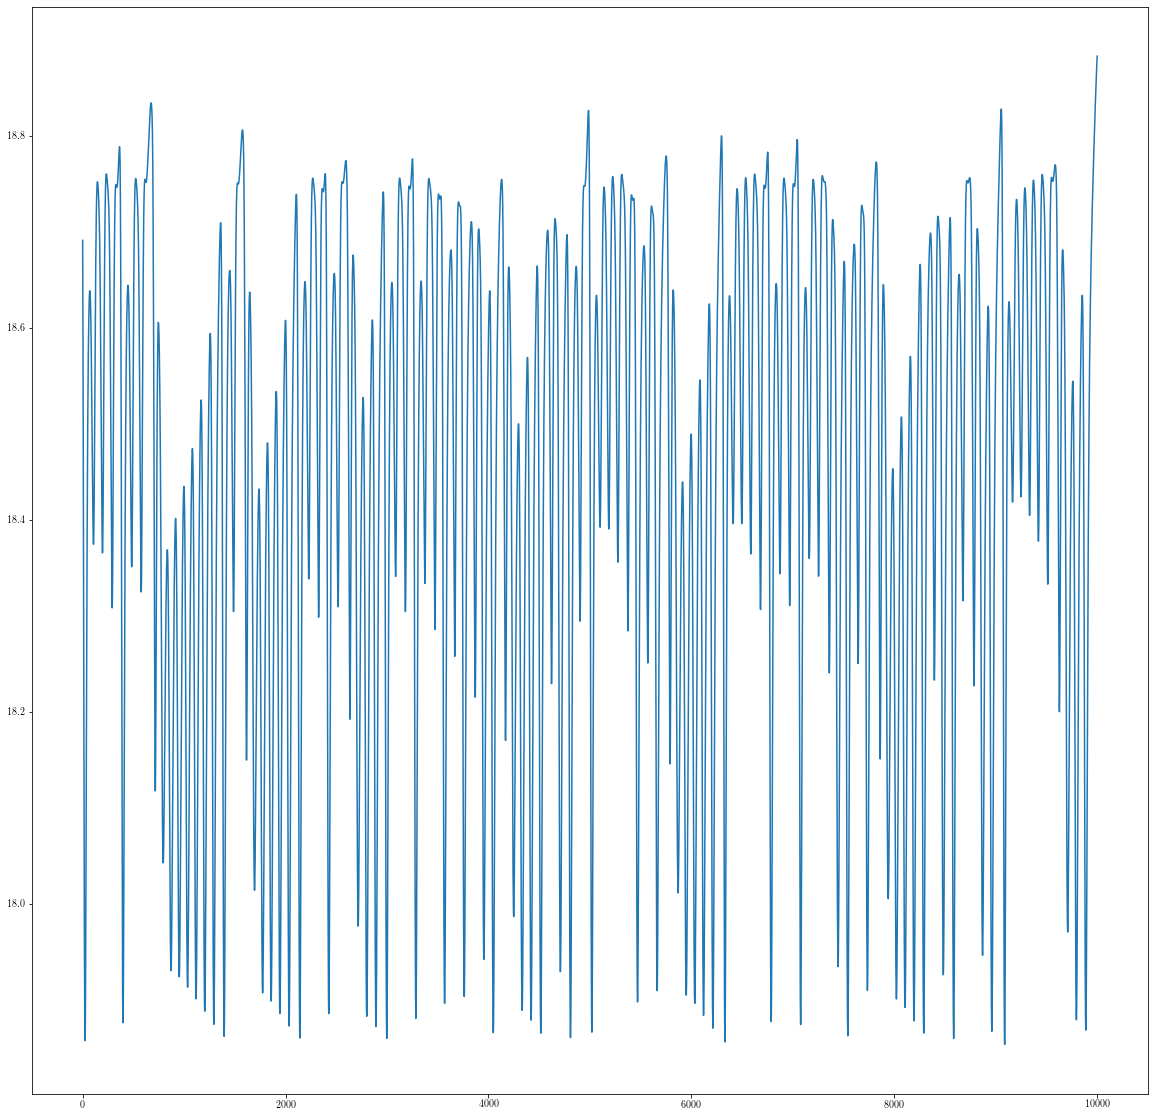

In [32]:
plt.figure(figsize=(20,20))
plt.plot(J[:,1,1])